# Problem Statement

You are the sales manager for "BeerMart", an online beer store in the United States. You want to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy. You collect data about the ratings that the customers have given in the past

Data preparation
Choose only those beers that have at least N number of reviews.

    Figure out an appropriate value of N using EDA; this may not have one correct answer, but you should not choose beers that have an extremely low number of ratings.

Data exploration

    What are the unique values of ratings?

    Visualise the rating values and notice:

        The average beer ratings

        The average user ratings

        The average number of ratings given to the beers

        The average number of ratings given by the users

Recommendation Models

    Divide your data into training and testing dataset.

    Build user-based and item-based models.
    Determine how similar the first 10 users are to each other and visualise it.
    Compute and visualise the similarity between the first 10 beers.

    Compare the performance of the two models using test data and suggest the one that should be deployed.

     Give the names of the top 5 beers that you would recommend to the users 'cokes','genog' and 'giblet' using both the models.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('C:/Users/ashish.i.pandey/Downloads/beer_data.csv', encoding='iso-8859-1')

In [3]:
df.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [4]:
#checking % of missing values
df.isnull().sum() * 100 / len(df)

beer_beerid           0.000000
review_profilename    0.021009
review_overall        0.000000
dtype: float64

In [5]:
df.count()

beer_beerid           475984
review_profilename    475884
review_overall        475984
dtype: int64

In [6]:
#checking review count for each rating
df.review_overall.value_counts()

4.0    174804
4.5     97349
3.5     90804
3.0     49523
5.0     27176
2.5     17601
2.0     11615
1.5      3817
1.0      3289
0.0         6
Name: review_overall, dtype: int64

In [7]:
#Checking the review_profilename null rows
df.loc[df.review_profilename.isnull()].count()



beer_beerid           100
review_profilename      0
review_overall        100
dtype: int64

In [8]:
#since very small no. of rows for null values so removing those
df = df[~df.review_profilename.isnull()]

In [9]:

df.isnull().sum() * 100 / len(df)

beer_beerid           0.0
review_profilename    0.0
review_overall        0.0
dtype: float64

In [10]:
df.duplicated().sum()

580

In [11]:
df.drop_duplicates(keep = 'first', inplace = True)

In [12]:
df.duplicated().sum()

0

# Data preparation

#Choose only those beers that have at least N number of reviews.

In [13]:
reviews_count_beer_id = df.groupby('beer_beerid').review_overall.count().to_frame('Reviews_count').sort_values(by = "Reviews_count", ascending=False)


In [14]:
reviews_count_beer_id.head()

,Reviews_count
beer_beerid,
2093,980
412,972
1904,903
1093,845
92,817


In [15]:
reviews_count_beer_id.reset_index(inplace=True)

In [16]:
reviews_count_beer_id.head()

,beer_beerid,Reviews_count
0,2093,980
1,412,972
2,1904,903
3,1093,845
4,92,817


In [17]:
reviews_count_analyze = reviews_count_beer_id.Reviews_count.value_counts().to_frame().reset_index()

In [18]:
reviews_count_analyze.columns = ['number_of_reviews','number_of_beer_ids']

In [19]:
reviews_count_analyze.head()

,number_of_reviews,number_of_beer_ids
0,1,18066
1,2,6188
2,3,3072
3,4,1906
4,5,1344


In [20]:
#calculating percentage of each beer_id and also their cummulative percentage
reviews_count_analyze['percentage_beers'] = (reviews_count_analyze['number_of_beer_ids']*100)/reviews_count_analyze.number_of_beer_ids.sum()
reviews_count_analyze['cumulative_percentage_beers'] = reviews_count_analyze.percentage_beers.cumsum()

In [21]:
reviews_count_analyze.head(10)

,number_of_reviews,number_of_beer_ids,percentage_beers,cumulative_percentage_beers
0,1,18066,44.824335,44.824335
1,2,6188,15.353315,60.177650
2,3,3072,7.622072,67.799722
3,4,1906,4.729059,72.528781
4,5,1344,3.334657,75.863438
5,6,963,2.389341,78.252779
6,7,785,1.947697,80.200476
7,8,560,1.389440,81.589917
8,9,474,1.176062,82.765979
9,10,406,1.007344,83.773323


In [22]:
reviews_count_analyze.count()

number_of_reviews              442
number_of_beer_ids             442
percentage_beers               442
cumulative_percentage_beers    442
dtype: int64

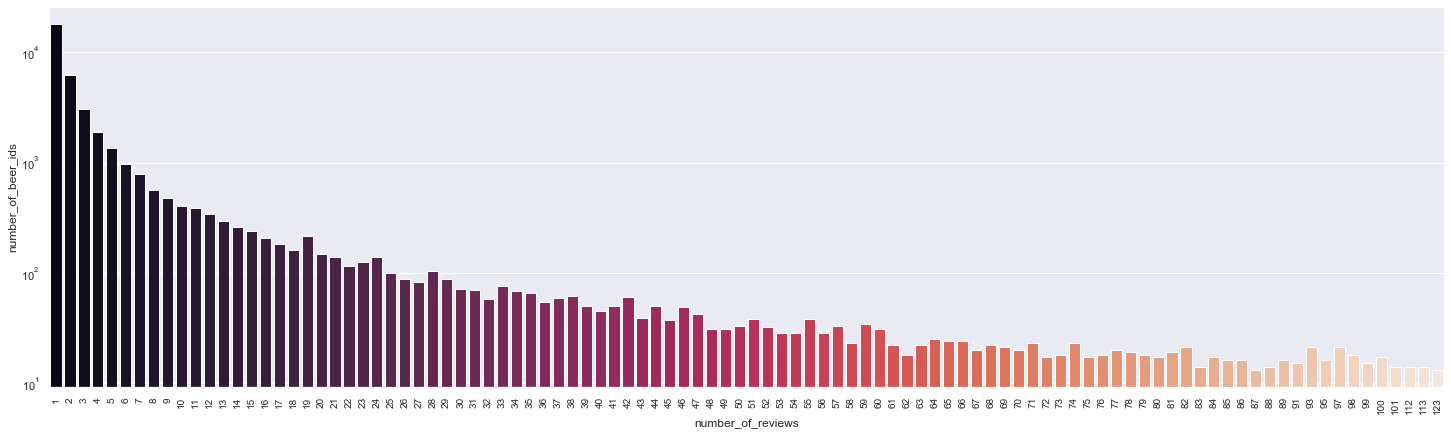

In [23]:
import seaborn as sns

sns.set(rc={'figure.figsize':(25,7)})
ax = sns.barplot(x=reviews_count_analyze[0:100].number_of_reviews, y=reviews_count_analyze[0:200].number_of_beer_ids, palette="rocket")
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=10)
ax



#There are more beerids having very less no of reviews.


In [24]:
reviews_count_by_profilename = df.groupby('review_profilename').review_overall.count().to_frame('count_reviews').sort_values(by = "count_reviews", ascending = False)

In [25]:
reviews_count_by_profilename.reset_index(inplace=True)

In [26]:
reviews_count_by_profilename.head()

,review_profilename,count_reviews
0,northyorksammy,1844
1,mikesgroove,1377
2,BuckeyeNation,1337
3,Thorpe429,1072
4,ChainGangGuy,1046


In [27]:
reviews_count_by_profilename.count()

review_profilename    22497
count_reviews         22497
dtype: int64

In [28]:
#now lets explore number of users with number of reviews they have given
reviews_count_user = reviews_count_by_profilename.count_reviews.value_counts().to_frame().reset_index()


In [29]:
reviews_count_user.columns = ['number_of_reviews','number_of_users']

In [30]:
reviews_count_user.head()

,number_of_reviews,number_of_users
0,1,7976
1,2,2948
2,3,1621
3,4,1108
4,5,841


In [31]:
reviews_count_user.count()

number_of_reviews    480
number_of_users      480
dtype: int64

In [32]:
reviews_count_user['percentage_users'] = (reviews_count_user['number_of_users']*100)/reviews_count_user.number_of_users.sum()
reviews_count_user['cumul_percentage_users'] = reviews_count_user.percentage_users.cumsum()

In [33]:
reviews_count_user.head()

,number_of_reviews,number_of_users,percentage_users,cumul_percentage_users
0,1,7976,35.453616,35.453616
1,2,2948,13.103969,48.557585
2,3,1621,7.205405,55.762991
3,4,1108,4.925101,60.688092
4,5,841,3.738276,64.426368


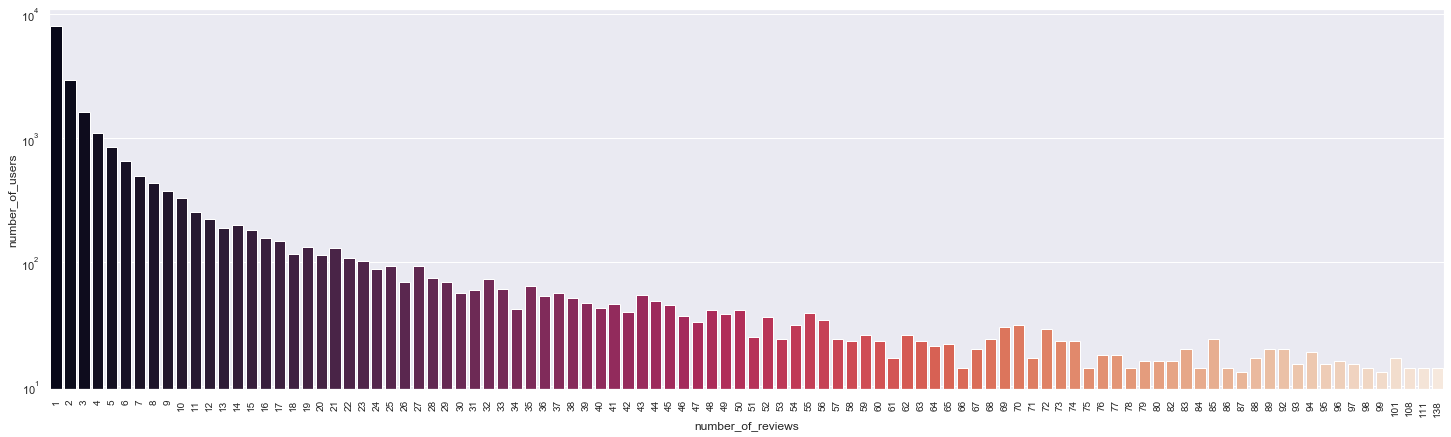

In [34]:
#visualizing number of users with number of reviews

sns.set(rc={'figure.figsize':(25,7)})
ax = sns.barplot(x=reviews_count_user[0:100].number_of_reviews, y=reviews_count_user[0:200].number_of_users, palette="rocket")
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=10)
ax

# Data exploration

In [35]:
#unique values for each metric
df.beer_beerid.nunique()

40304

In [36]:
df.review_profilename.nunique()

22497

In [37]:
df.review_overall.nunique()

10

In [38]:
df.beer_beerid.count()

475304

#As per problem to filter N for only Beer wise reviews we will remove records for users who have given less than 30 reviews.

#we will also remove the users  who have given less than 30 reviews

In [39]:
beer_ids_no_of_ratings_grt_30 = reviews_count_beer_id.loc[reviews_count_beer_id.Reviews_count>=30].beer_beerid.to_frame('beer_beerid')
users_no_of_ratings_grt_30 = reviews_count_by_profilename.loc[reviews_count_by_profilename.count_reviews>=30].review_profilename.to_frame('review_profilename')



In [40]:
rating2 = pd.merge(df, beer_ids_no_of_ratings_grt_30, how='inner', on='beer_beerid')
rating2 = pd.merge(rating2, users_no_of_ratings_grt_30, how='inner', on='review_profilename')


In [41]:
rating2.head()

,beer_beerid,review_profilename,review_overall
0,436,Brent,3.0
1,10784,Brent,4.0
2,10785,Brent,4.0
3,16074,Brent,4.0
4,33644,Brent,4.0


In [42]:
rating2.count()

beer_beerid           265348
review_profilename    265348
review_overall        265348
dtype: int64

unique values of ratings

In [43]:
np.sort(rating2.review_overall.unique())



array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [44]:
rating2.head()

,beer_beerid,review_profilename,review_overall
0,436,Brent,3.0
1,10784,Brent,4.0
2,10785,Brent,4.0
3,16074,Brent,4.0
4,33644,Brent,4.0



The average beer ratings

In [45]:
rating2.groupby('beer_beerid').review_overall.mean()

beer_beerid
5        3.532609
6        3.707895
7        3.273649
9        3.344828
10       3.859116
14       3.911765
15       3.788889
17       3.420330
19       4.012097
23       3.983333
30       4.085470
31       3.966667
32       4.034091
33       4.122973
34       4.255102
36       4.117647
39       4.325826
54       3.685484
55       3.954545
56       3.460000
58       3.969466
59       4.230000
61       4.103943
63       4.076408
65       2.802632
66       2.500000
67       3.722892
69       3.608333
72       3.637931
73       4.025581
74       3.564024
78       3.849057
79       4.068702
80       3.760000
81       3.836957
82       3.604167
83       3.534653
85       4.037234
86       3.894737
87       4.076271
88       4.246331
89       4.103659
90       4.073204
92       4.122824
93       3.852941
96       4.200935
97       3.650000
99       3.855556
100      3.112403
101      3.778626
102      3.783208
103      3.601286
104      4.015837
108      3.126697
111      2.42000

(array([1.000e+00, 6.000e+00, 1.200e+01, 3.100e+01, 5.500e+01, 1.520e+02,
        4.930e+02, 1.359e+03, 9.290e+02, 9.200e+01]),
 array([1.25833333, 1.59613636, 1.93393939, 2.27174242, 2.60954545,
        2.94734848, 3.28515152, 3.62295455, 3.96075758, 4.29856061,
        4.63636364]),
 <a list of 10 Patch objects>)

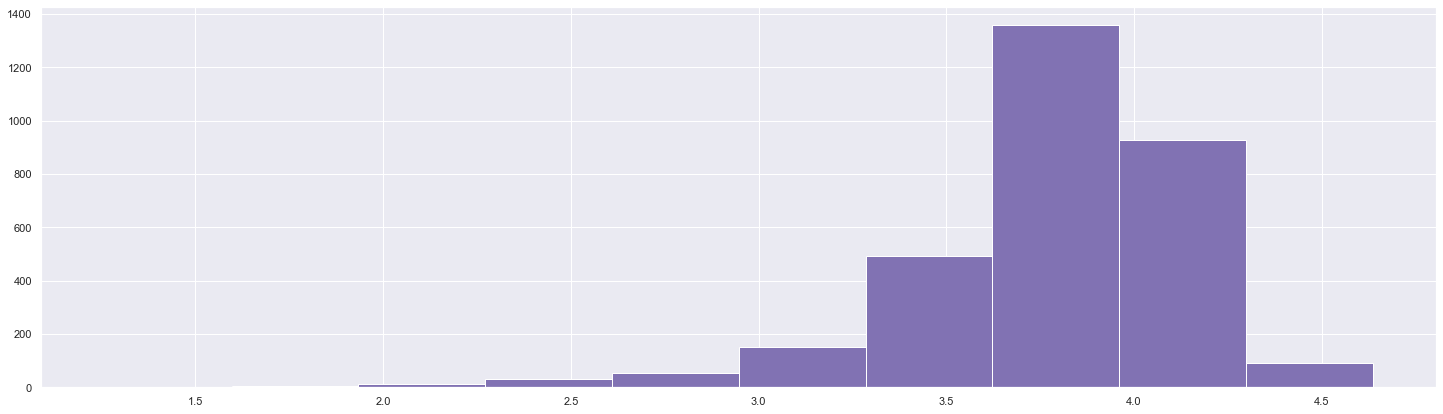

In [46]:
plt.hist(rating2.groupby('beer_beerid').review_overall.mean(), color="m")

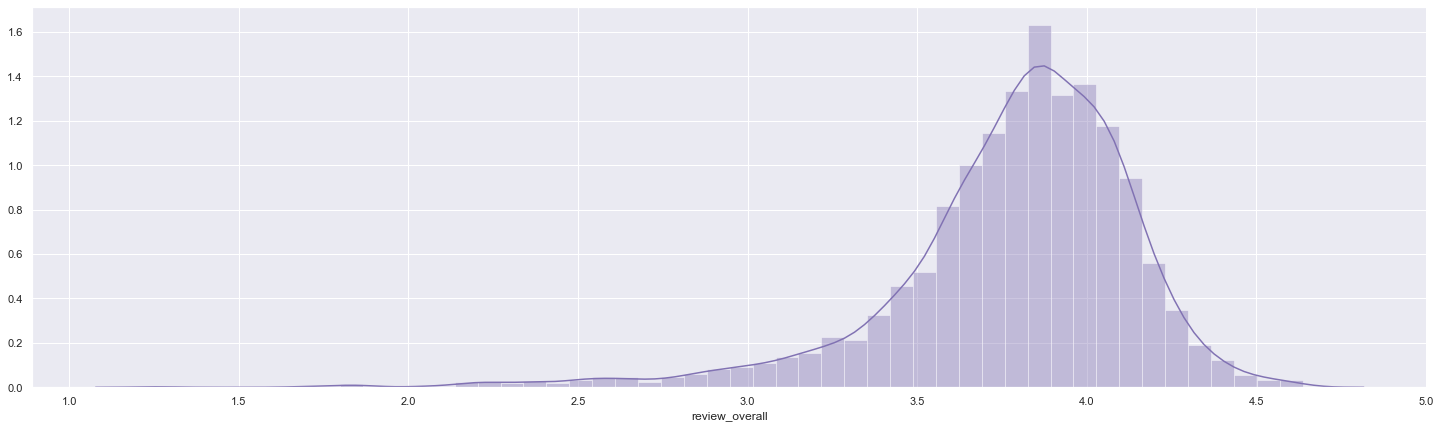

In [47]:
#sns.distplot(rating2.groupby('beer_beerid').review_overall.mean(), kde=False, color="b")
sns.distplot(rating2.groupby('beer_beerid').review_overall.mean(), color="m")



In [48]:
rating2.groupby('beer_beerid').review_overall.mean().mean()

3.7837973354284613


The average user ratings


In [49]:
rating2.groupby('review_profilename').review_overall.mean()

review_profilename
0110x011            4.333333
05Harley            4.136364
100floods           4.069444
1759Girl            3.663043
1fastz28            3.850467
32hoss32            3.774194
3Vandoo             3.826531
4000qtrap           3.782051
4DAloveofSTOUT      3.965517
51mmz0rz            4.095238
7ways               3.396552
86sportster883      4.000000
99bottles           3.944444
9InchNails          3.544872
ABOWMan             3.648148
AChamberlain        3.895161
ADR                 3.657795
ADZA                3.964286
AEK                 4.033333
AKBelgianBeast      4.200535
ALESwhatCURESya     3.829545
ATLbeerDog          3.782609
ATPete              3.870079
AWolfAtTheDoor      3.825000
AaronHomoya         3.840580
AaronRed            4.223077
Absumaster          3.659836
AdamBear            3.953901
AdamGarcia          3.851351
AdmiralDiaz         4.126984
Admiraldinty        3.965116
Aenema              3.816176
AgentMunky          3.866142
AgentZero           3.55

(array([   8.,   20.,   49.,  105.,  308.,  704., 1013.,  738.,  194.,
          37.]),
 array([2.859375  , 3.01908967, 3.17880435, 3.33851902, 3.4982337 ,
        3.65794837, 3.81766304, 3.97737772, 4.13709239, 4.29680707,
        4.45652174]),
 <a list of 10 Patch objects>)

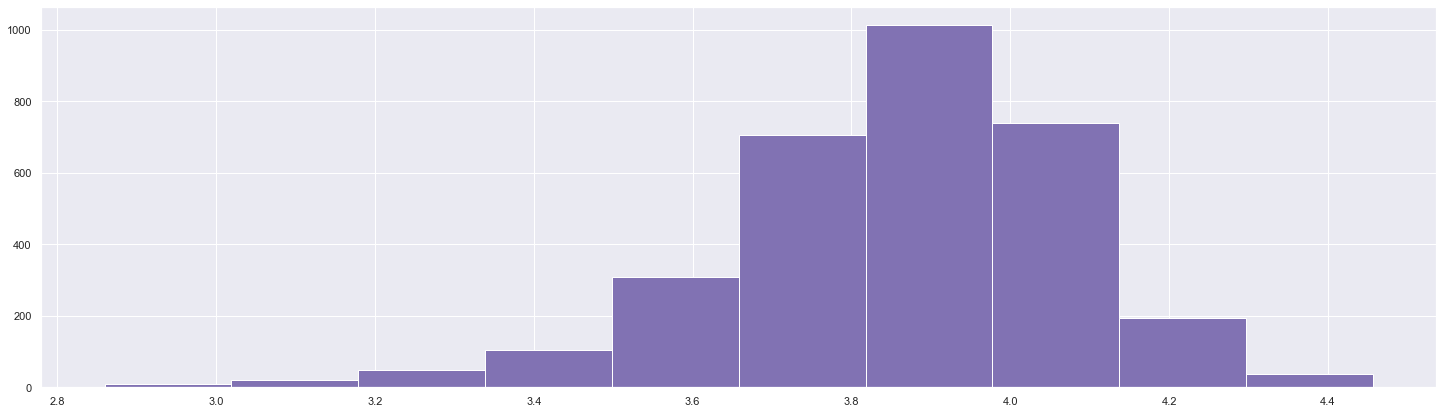

In [50]:
plt.hist(rating2.groupby('review_profilename').review_overall.mean(), color="m")

In [51]:
rating2.groupby('review_profilename').review_overall.mean().mean()

3.8607538534577253

The average number of ratings given to the beers

In [52]:
#we already deleted beerid records having only upto 5 ratings, so lets reform this dataframe.

In [53]:
reviews_count_beer_id2 = rating2.groupby('beer_beerid').review_overall.count().to_frame('Reviews_count').sort_values(by = "Reviews_count", ascending = False)

In [54]:
reviews_count_beer_id2.head()

,Reviews_count
beer_beerid,
2093,603
412,595
1904,575
1093,557
4083,531


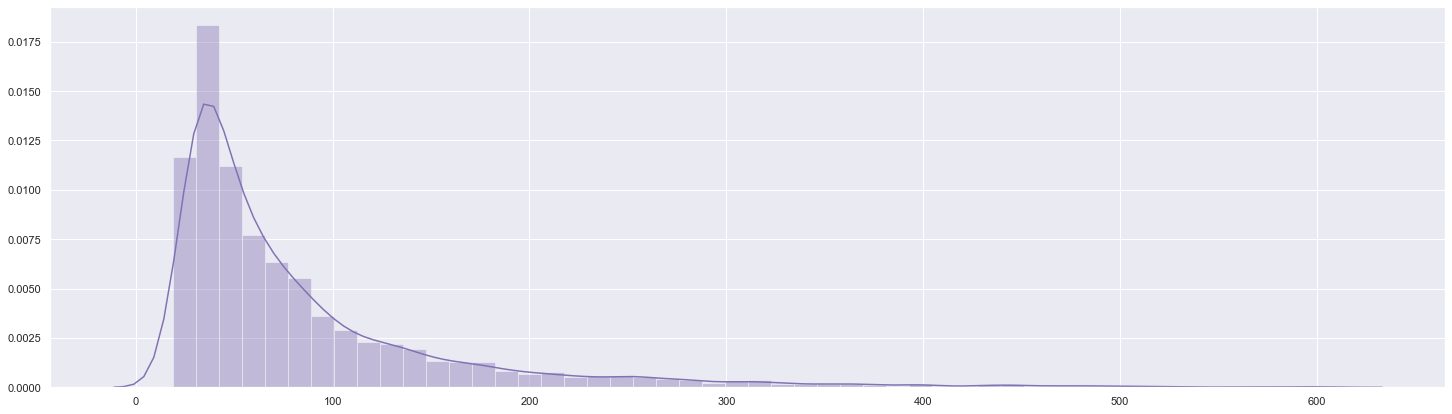

In [55]:
sns.distplot(reviews_count_beer_id2, color="m")

In [56]:
reviews_count_beer_id2.Reviews_count.mean()

84.77571884984026

The average number of ratings given by the users¶


In [57]:


review_count_user = rating2.groupby('review_profilename').review_overall.count().to_frame('Reviews_count').sort_values(by = "Reviews_count", ascending = False)



In [58]:
review_count_user.head()

,Reviews_count
review_profilename,
BuckeyeNation,697
mikesgroove,689
northyorksammy,617
brentk56,607
WesWes,584


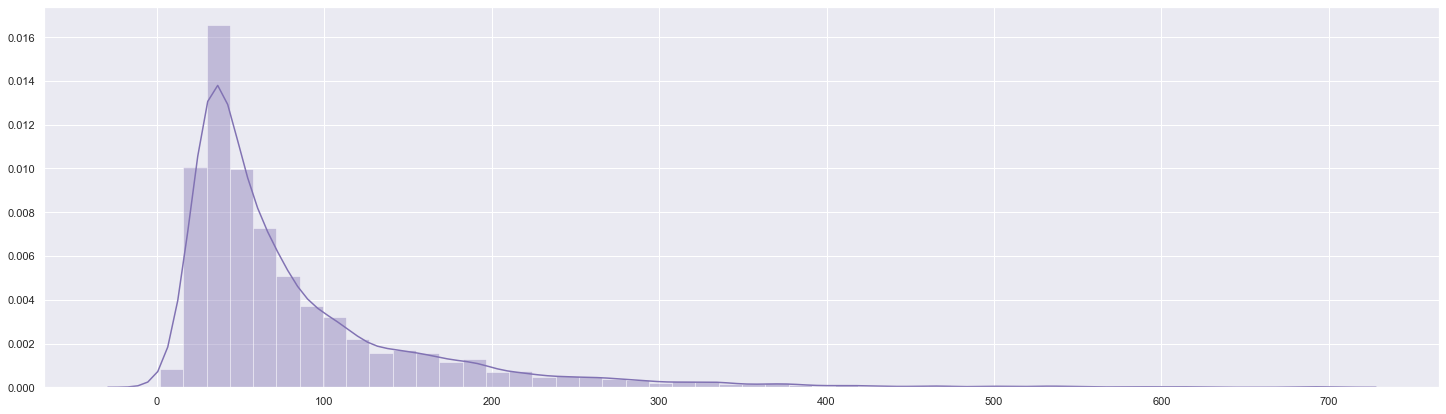

In [59]:
sns.distplot(review_count_user, color="m")

In [60]:
review_count_user.Reviews_count.mean()

83.54785894206549

# Recommendation Models

#splitting dataset into test and train set

In [61]:
import sklearn
from sklearn.model_selection import train_test_split

In [62]:
train, test = train_test_split(rating2, test_size=0.30, random_state=31)

In [63]:
print(train.shape)
print(test.shape)

(185743, 3)
(79605, 3)


Building user-based and item-based models.

In [64]:
train.head()

,beer_beerid,review_profilename,review_overall
145506,56761,bort11,4.5
55331,59,Treebs,4.0
8211,818,DrJay,4.0
86994,1149,beerthulhu,4.0
235723,63,yesyouam,4.5


In [65]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [66]:
train.head()

,beer_beerid,review_profilename,review_overall
0,56761,bort11,4.5
1,59,Treebs,4.0
2,818,DrJay,4.0
3,1149,beerthulhu,4.0
4,63,yesyouam,4.5


In [67]:
# pivot ratings beer features
df_beer_features = train.pivot_table(index='review_profilename',columns='beer_beerid',values='review_overall').fillna(0)

In [68]:
df_beer_features.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we will follow dummy train-test analogy as studied in Recommendation systems module--

Lets first Copy train and test dataset

These dataset further will be used for prediction and evaluation.

Dummy train will be used later for prediction of the beers which has not been rated by the user. To ignore the beers rated by the user, we will mark it as 0 during prediction. The beers not rated by user is marked as 1 for prediction.
Dummy test will be used for evaluation. To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [69]:
dummy_train = train.copy()
dummy_test = test.copy()

In [70]:
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [71]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [72]:
dummy_train.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100floods,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1759Girl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1fastz28,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [73]:
dummy_test.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# User Similarity Matrix


# Using Cosine Similarity

In [75]:
from sklearn.metrics.pairwise import pairwise_distances

#User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_beer_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

In [76]:
print(user_correlation)

[[1.         0.         0.         ... 0.03689843 0.07491462 0.        ]
 [0.         1.         0.03626398 ... 0.         0.05053392 0.        ]
 [0.         0.03626398 1.         ... 0.         0.         0.        ]
 ...
 [0.03689843 0.         0.         ... 1.         0.04676159 0.        ]
 [0.07491462 0.05053392 0.         ... 0.04676159 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [77]:
user_correlation.shape

(3176, 3176)

#Here, not removing the NaN values and calculating the mean only for the beers rated by the user

In [78]:
beer_features = train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [79]:
beer_features.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Normalising the rating of the beer for each user aroung 0 mean


In [80]:
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [81]:
df_subtracted.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,NaN,NaN,-1.901316,0.098684,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Finding cosine similarity

In [82]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.          0.          0.         ... -0.00287314  0.05048843
   0.        ]
 [ 0.          1.          0.00397706 ...  0.          0.06906591
   0.        ]
 [ 0.          0.00397706  1.         ...  0.          0.
   0.        ]
 ...
 [-0.00287314  0.          0.         ...  1.         -0.00729601
   0.        ]
 [ 0.05048843  0.06906591  0.         ... -0.00729601  1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


# Prediction

we are doing the prediction for the users which are positively related with other users, 
and not the users which are negatively related as 
we are interested in the users which are more similar to the current users. 
So, ignoring the correlation for values less than 0.


In [83]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.05048843,
        0.        ],
       [0.        , 1.        , 0.00397706, ..., 0.        , 0.06906591,
        0.        ],
       [0.        , 0.00397706, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05048843, 0.06906591, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])



Rating predicted by the user (for beers rated as well as not rated) is the weighted sum of correlation with the beer rating (as present in the rating dataset)

user_predicted_ratings = np.dot(user_correlation, beer_features.fillna(0))
user_predicted_ratings

In [85]:
user_predicted_ratings.shape

(3176, 3130)

Since we are interested only in the beers not rated by the user, we will ignore the beers rated by the user by making it zero.

In [86]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.965780,2.018581,1.707527,0.191303,2.736811,0.424313,0.765378,2.991204,2.076549,0.476055,...,1.121473,0.535821,0.492305,1.089059,0.569360,0.916923,0.584773,2.689674,1.997331,1.588596
05Harley,2.325783,4.087927,3.161748,0.841821,5.086790,0.611400,1.616928,3.890993,3.044091,1.207020,...,2.500406,0.767853,0.797210,1.511991,2.838024,1.269313,0.044894,7.165247,3.005958,2.564080
100floods,0.850382,1.205313,1.111173,0.124479,2.404978,0.458694,0.701138,1.776628,0.818848,0.243832,...,0.839890,0.734261,0.435310,0.139930,0.390296,0.547865,0.055615,1.494371,0.468750,1.860586
1759Girl,4.911258,4.564037,5.075467,0.846740,6.469763,2.156379,1.580147,6.835016,4.948824,0.738676,...,1.792223,2.155537,1.140080,1.270895,1.539095,1.393871,0.652661,3.717480,1.344436,1.778877
1fastz28,3.188549,5.518802,4.937574,0.000000,0.000000,2.178272,2.363760,6.332384,5.925424,1.124779,...,2.690741,1.328768,1.719658,1.693226,1.076154,1.090621,0.682363,3.241540,1.589986,2.875416


In [87]:
#Finding the top 5 recommendation for the user 1
user_final_rating.iloc[0].sort_values(ascending=False)[0:5]

beer_beerid
19960    14.299709
7971     14.104097
645      13.524962
1708     12.856361
1056     12.843069
Name: 0110x011, dtype: float64


Item Based Similarity
Using Correlation



Taking the transpose of the rating matrix to normalize the rating around the mean for different beer id. In the user based similarity, we had taken mean for each user intead of each beer

beer_features = train.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

beer_features.head()

Normalising the beer rating for each beer

In [89]:
mean = np.nanmean(beer_features, axis=1)
df_subtracted1 = (beer_features.T-mean).T

df_subtracted1.head()



Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value.


In [91]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted1.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00 -4.18735321e-02  1.47561968e-02 ...  0.00000000e+00
  -3.28321564e-02  2.19234082e-04]
 [-4.18735321e-02  1.00000000e+00  7.23316842e-02 ...  3.79765925e-03
   6.75744368e-02 -6.03070718e-02]
 [ 1.47561968e-02  7.23316842e-02  1.00000000e+00 ...  9.27828820e-03
   0.00000000e+00  3.07573134e-02]
 ...
 [ 0.00000000e+00  3.79765925e-03  9.27828820e-03 ...  1.00000000e+00
  -1.93443125e-02 -1.48348127e-02]
 [-3.28321564e-02  6.75744368e-02  0.00000000e+00 ... -1.93443125e-02
   1.00000000e+00 -7.51188957e-03]
 [ 2.19234082e-04 -6.03070718e-02  3.07573134e-02 ... -1.48348127e-02
  -7.51188957e-03  1.00000000e+00]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [92]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1.00000000e+00, 0.00000000e+00, 1.47561968e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.19234082e-04],
       [0.00000000e+00, 1.00000000e+00, 7.23316842e-02, ...,
        3.79765925e-03, 6.75744368e-02, 0.00000000e+00],
       [1.47561968e-02, 7.23316842e-02, 1.00000000e+00, ...,
        9.27828820e-03, 0.00000000e+00, 3.07573134e-02],
       ...,
       [0.00000000e+00, 3.79765925e-03, 9.27828820e-03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.75744368e-02, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.19234082e-04, 0.00000000e+00, 3.07573134e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Prediction

item_predicted_ratings = np.dot((beer_features.fillna(0).T),item_correlation)
item_predicted_ratings

In [94]:
item_predicted_ratings.shape

(3176, 3130)

In [95]:
dummy_train.shape

(3176, 3130)

Filtering the rating only for the movies not rated by the user for recommendation

In [96]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.576743,1.130903,0.739607,0.440113,0.558811,0.839613,0.701350,0.837393,1.122386,0.756538,...,0.481393,0.615804,0.937988,1.128974,1.470148,1.513260,0.177026,0.762177,1.441748,1.303320
05Harley,1.361148,1.394032,1.358252,0.303531,1.808114,1.310874,1.318404,0.679379,0.432173,1.422885,...,0.626430,1.050201,0.705413,1.325326,0.333372,0.285802,0.342553,0.938091,0.754355,0.396728
100floods,0.540561,0.949464,1.275505,0.389847,1.445187,0.247851,0.987572,0.493343,0.380118,0.279248,...,0.590872,0.842291,0.420519,1.050278,0.508464,0.507181,0.371654,0.612494,1.016730,0.900809
1759Girl,1.292439,1.044237,1.430945,1.575382,1.441777,1.171636,1.024068,1.611016,0.879140,0.818644,...,1.050526,1.089145,1.129967,2.191113,1.398335,0.702157,0.557120,1.079003,1.555864,2.107833
1fastz28,2.838872,3.551099,3.629377,0.000000,0.000000,4.039063,3.766577,3.355648,3.215155,3.635153,...,1.381762,1.550306,1.209108,2.306759,1.135555,2.127456,0.834631,3.011108,2.081335,2.841907


In [97]:
#Top 5 prediction for the user -1


item_final_rating.iloc[0].sort_values(ascending=False)[0:5]

beer_beerid
51116    3.817788
41690    3.812950
39873    3.717200
55139    3.529913
60886    3.516672
Name: 0110x011, dtype: float64

Determine how similar the first 10 users are to each other and visualise it.

In [98]:
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.05048843,
        0.        ],
       [0.        , 1.        , 0.00397706, ..., 0.        , 0.06906591,
        0.        ],
       [0.        , 0.00397706, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05048843, 0.06906591, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [99]:
user_correlation.shape

(3176, 3176)



We will create another copy of user_correlation and set the diagonal elements to 0, as they are correlations of the users with itself.


In [100]:
user_correlation1= user_correlation

In [101]:
np.fill_diagonal(user_correlation1, 0)

In [102]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [103]:
a = largest_indices(user_correlation1, 20)
a

(array([2371, 1191, 1255,  349, 2993,  937, 1467, 1787, 1800,  963, 1742,
        2679, 2679,  671, 1521, 2210, 1198, 1229, 1304, 2684], dtype=int64),
 array([1191, 2371,  349, 1255,  937, 2993, 1787, 1467,  963, 1800, 2679,
        1742,  671, 2679, 2210, 1521, 1229, 1198, 2684, 1304], dtype=int64))

In [104]:
user_correlation1[largest_indices(user_correlation1, 20)]

array([0.7079514 , 0.7079514 , 0.67583782, 0.67583782, 0.67283787,
       0.67283787, 0.67193179, 0.67193179, 0.66915884, 0.66915884,
       0.60614133, 0.60614133, 0.60597632, 0.60597632, 0.59860972,
       0.59860972, 0.59251619, 0.59251619, 0.58885684, 0.58885684])

In [105]:
for i in list(a[0]):
     print(str(i) + "-" + beer_features.columns.get_values()[i])

2371-macster
1191-Sweasty
1255-Thehuntmaster
349-Daredevil
2993-tippebrewcrew2
937-OzarkElmo
1467-b3shine
1787-danielocean03
1800-dbaker61
963-Pepeton
1742-cooch69
2679-pwsoldier
2679-pwsoldier
671-JoeMayo
1521-beeronthebrain
2210-jminsc76
1198-TCHopCraver
1229-TheBlackMallard
1304-Umbra
2684-rabsten


largest_indices(user_correlation1, 20)



heat map for comparing the ratings for Beers that they have rated m

sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df_subtracted.iloc[:,list(a[0])].dropna(thresh=1),cmap='RdBu')



Adjacent pairs (gestyr,bboelens), (jushoppy2beer, Rio), (bboelens, Mississipping) and so on were correlated as per user similarity matrix, corresponding heat map above.



4 .Compute and visualise the similarity between the first 10 beers



Again my assumption here is that by first 10 beers it is meant that first 10 pairs of beers with highest correlations. Similar to users, we will find the same for beers and plot heat map.


item_correlation

In [109]:
item_correlation.shape

(3130, 3130)



We will create another copy of item_correlation and set the diagonal elements to 0, as they are correlations of the beers with itself.


In [110]:
item_correlation1 = item_correlation

np.fill_diagonal(item_correlation1, 0)
b = largest_indices(item_correlation1, 20)
b



(array([2942, 2745, 2557, 2745, 2393, 2460, 2942, 2557, 2393, 2103, 2393,
        1477, 2837, 1004,  311,  669, 2745, 2957, 1084, 1757], dtype=int64),
 array([2745, 2942, 2745, 2557, 2460, 2393, 2557, 2942, 2103, 2393, 1477,
        2393, 1004, 2837,  669,  311, 2957, 2745, 1757, 1084], dtype=int64))

In [111]:
item_correlation1[largest_indices(item_correlation1, 20)]

array([0.61980878, 0.61980878, 0.59769493, 0.59769493, 0.56286936,
       0.56286936, 0.55486753, 0.55486753, 0.55354184, 0.55354184,
       0.55145185, 0.55145185, 0.55077048, 0.55077048, 0.54720875,
       0.54720875, 0.54685519, 0.54685519, 0.54128634, 0.54128634])

In [112]:
#heat map for comparing ratings of similar beers
#index to beer_id mapping
for i in list(b[0]):
   print(str(i) + "-" + str(beer_features.T.columns.get_values()[i]))

2942-58675
2745-51498
2557-46085
2745-51498
2393-41690
2460-43328
2942-58675
2557-46085
2393-41690
2103-34363
2393-41690
1477-13416
2837-54730
1004-3307
311-723
669-1714
2745-51498
2957-59173
1084-3997
1757-22992


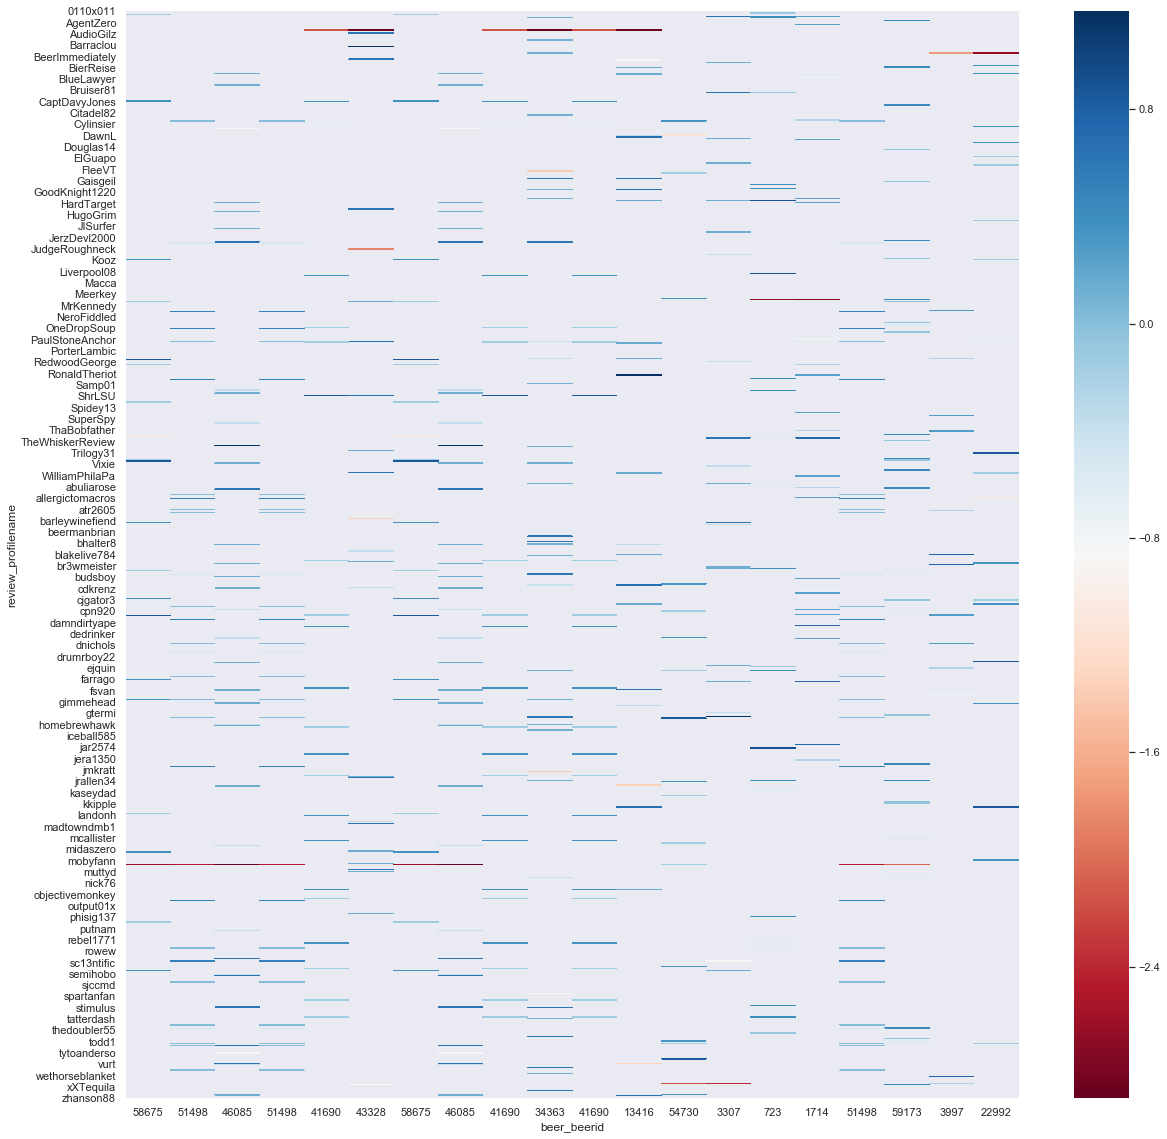

In [113]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(df_subtracted1.iloc[list(b[0]),:].dropna(thresh=1).T,cmap='RdBu')

Compare the performance of the two models using test data and suggest the one that should be deployed.

Evaluations on test data

Using User Similarity

In [114]:
test.head()

,beer_beerid,review_profilename,review_overall
0,312,everetends,4.0
1,1914,jjayjaye,4.0
2,1180,aristeros,4.5
3,21300,BeanBone,4.0
4,1346,IntriqKen,5.0


In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79605 entries, 0 to 79604
Data columns (total 3 columns):
beer_beerid           79605 non-null int64
review_profilename    79605 non-null object
review_overall        79605 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [116]:
test_beer_features = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.02737245 0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.02737245 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [117]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_beer_features.fillna(0))
test_user_predicted_ratings

array([[0.10550305, 0.52185871, 0.28580915, ..., 0.02952382, 0.07181627,
        0.0490052 ],
       [0.38768401, 0.45002176, 0.84877108, ..., 0.1290616 , 0.28881822,
        0.14537417],
       [0.        , 0.73943327, 0.12201097, ..., 0.63099043, 0.        ,
        0.23281806],
       ...,
       [0.9604079 , 1.98096237, 1.00563362, ..., 1.11553605, 0.        ,
        0.47138822],
       [0.24862137, 3.79577197, 0.7390267 , ..., 1.18838085, 0.01152604,
        0.05215595],
       [0.08554925, 2.70765505, 1.34479262, ..., 0.21674648, 0.15920356,
        0.40941911]])

Doing prediction for the beers rated by the user

In [118]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)
test_user_final_rating.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,5.345961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [119]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [120]:
test_ = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [121]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [122]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.7250379412127204


In [123]:
#Using Item Similarity
test_beer_features = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [124]:
test_item_correlation.shape

(3130, 3130)

In [125]:
test_beer_features.shape

(3130, 3175)

In [126]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,4.900708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
test_ = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [130]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot_table(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


Finding RMSE

In [131]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.184570092719688


RMSE for User Based Collaborative Filtering on test data : 1.7250379412127204
RMSE for Item Based Collaborative Filtering on test data : 2.184570092719688
So the User Based Collaborative Filtering has performed better here.
So the model which should be deployed would be User Based Collaborative Filtering.¶


Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

In [132]:
#Top 5 beer recommendations to Cokes using User Collaborative Filtering Model
user_final_rating.loc['cokes',:].sort_values(ascending=False)[0:5]

beer_beerid
695     30.699481
276     30.697503
34      28.386749
92      28.345283
1708    28.251610
Name: cokes, dtype: float64

In [133]:
#Top 5 beer recommendations to genog using User Collaborative Filtering Model
user_final_rating.loc['genog',:].sort_values(ascending=False)[0:5]

beer_beerid
1093     34.601014
11757    28.657487
276      28.582798
1708     28.505738
34       27.737288
Name: genog, dtype: float64

In [134]:
#Top 5 beer recommendations to giblet using User Collaborative Filtering Model
user_final_rating.loc['giblet',:].sort_values(ascending=False)[0:5]

beer_beerid
2093    42.040944
1093    39.839682
355     39.564124
104     39.406632
6108    37.855620
Name: giblet, dtype: float64

In [135]:
#Top 5 beer recommendations to Cokes using Item Collaborative Filtering Model
item_final_rating.loc['cokes',:].sort_values(ascending=False)[0:5]

beer_beerid
248      16.930648
28268    16.672941
2147     16.626841
33467    16.272491
799      15.769285
Name: cokes, dtype: float64

In [136]:
#Top 5 beer recommendations to genog using Item Collaborative Filtering Model
item_final_rating.loc['genog',:].sort_values(ascending=False)[0:5]

beer_beerid
56396    5.994355
38426    5.567286
37294    5.469528
9135     5.346328
49151    5.314365
Name: genog, dtype: float64

In [137]:
#Top 5 beer recommendations to giblet using Item Collaborative Filtering Model
item_final_rating.loc['giblet',:].sort_values(ascending=False)[0:5]

beer_beerid
36656    6.338400
1714     6.036315
142      5.996169
2940     5.489044
33200    5.487583
Name: giblet, dtype: float64